# KL Approximation

From: http://joschu.net/blog/kl-approx.html


There are three approzimations suggested in the blog. Our target of the approximation is

$$ \textrm{KL}(q||p) = \int q(x) \log \frac{q(x)}{p(x)} dx $$.

The motivation of the calculation of this value is the approximating the KL-reguralization of the polies of deep RL agents

$$ \textrm{KL}(\pi_\textrm{old}||\pi) = \int \pi_\textrm{old}(a|s) \log \frac{\pi_\textrm{old}(a|s)}{\pi(a|s)} da $$,

where $q = \pi_\textrm{old}$ and $p = \pi$.

Using $r(x) = \frac{p(x)}{q(x)}$ and the sampling number $N$ for $x \sim q(x)$, 

$$ \textrm{AKL}_1 = \frac{1}{N} \sum_{n=1}^N  \bigl(- \log r(x_n)\bigr)$$

and 

$$ \textrm{AKL}_2 = \frac{1}{N} \sum_{n=1}^N \frac{1}{2} \bigl(\log r(x_n) \bigr)^2$$,

and finally

$$ \textrm{AKL}_3 = \frac{1}{N} \sum_{n=1}^N \bigl(r(x_n) - 1\bigr) - \log r(x_n)$$.


I will compare the performance of the approximation.

### Comparison

- Noral distribution

1. sample the mean of $p$ and $q$ from a normal distribution
2. calculate approximated KLs between $p$ and $q$
3. calculate the absolute error from an analytical KL divergence and the standard deviation of akl
4. iterate plotting and sampling many times to visualize

- Beta distribution with concentrations larger than one.

1. sample the concentration parameters ($c_0, c_1 > 1$) of Beta dist. for $p$ and $q$ from an uniform distribution
2. calculate approximated KLs between $p$ and $q$
3. calculate the absolute error from an analytical KL divergence and the standard deviation of akl
4. iterate plotting and sampling many times to visualize


## Prereration

In [104]:
import torch
import torch.distributions as dis
import matplotlib.pyplot as plt
import numpy as np

alpha = 0.1
n_lines = 1000

#N_list = [10, 100, 1_000, 10_000, 100_000, 1_000_000]
#N_list = np.linspace(start=10, stop=10000, num=int(10000/10), endpoint=True, dtype=np.int)
N_list = [2**i for i in [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]

print(N_list)

[8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]


# Normal Distribution

<ipython-input-105-e3c88066b2dd>:47: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211)
<ipython-input-105-e3c88066b2dd>:56: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)


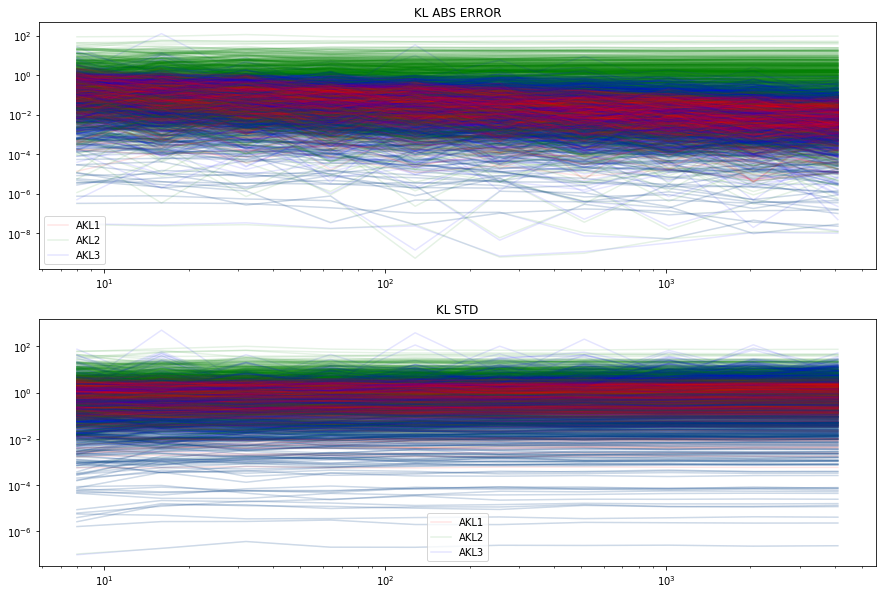

In [105]:
# normal distribution

def get_loc():
    return np.random.randn()


plt.figure(figsize=(15, 10))

for _ in range(n_lines):
    loc_q = get_loc()
    loc_p = get_loc()

    #print("loc p, q: ", loc_p, loc_q)

    p = dis.Normal(loc=loc_p, scale=1)
    q = dis.Normal(loc=loc_q, scale=1)

    truekl = dis.kl_divergence(p, q)

    e_akl1, e_akl2, e_akl3 = [], [], []
    std1, std2, std3 = [], [], []

    for N in N_list:
        x = q.sample(sample_shape=(N,))

        logr = p.log_prob(x) - q.log_prob(x)

        k1 = -logr
        k2 = logr ** 2 / 2
        k3 = (logr.exp() - 1) - logr

        e_akl1.append(np.abs(k1.mean() - truekl))
        std1.append(k1.std())

        e_akl2.append(np.abs(k2.mean() - truekl))
        std2.append(k2.std())

        e_akl3.append(np.abs(k3.mean() - truekl))
        std3.append(k3.std())

        #print("N: ", N)
        #print("truekl: ", truekl)
        #for i, k in enumerate((k1, k2, k3)):
        #    print(f"akl_{i}", k.mean(), (k.mean() - truekl) / truekl, k.std() / truekl)


    plt.subplot(211)
    plt.title("KL ABS ERROR")
    plt.plot(N_list, e_akl1, alpha=alpha, color="r")
    plt.plot(N_list, e_akl2, alpha=alpha, color="g")
    plt.plot(N_list, e_akl3, alpha=alpha, color="b")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend(["AKL1", "AKL2", "AKL3"])

    plt.subplot(212)
    plt.title("KL STD")
    plt.plot(N_list, std1, alpha=alpha, color="r")
    plt.plot(N_list, std2, alpha=alpha, color="g")
    plt.plot(N_list, std3, alpha=alpha, color="b")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend(["AKL1", "AKL2", "AKL3"])

# Beta Distibution

<ipython-input-106-04bf9edeed8e>:40: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(211)
<ipython-input-106-04bf9edeed8e>:49: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(212)


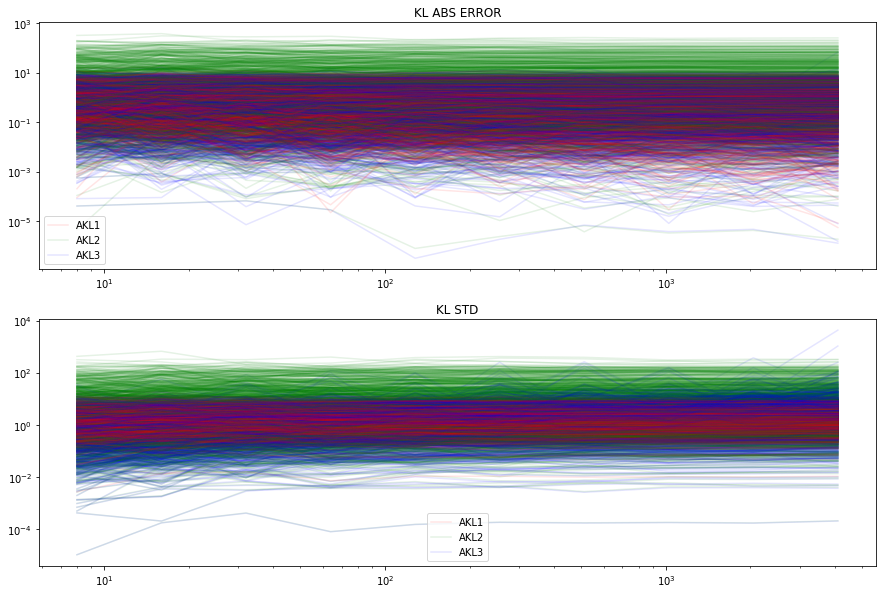

In [106]:
# normal distribution

def get_c():
    return np.random.rand() * 10 + 1

plt.figure(figsize=(15, 10))

for _ in range(n_lines):
    p = dis.Beta(get_c(), get_c())
    q = dis.Beta(get_c(), get_c())

    truekl = dis.kl_divergence(p, q)

    e_akl1, e_akl2, e_akl3 = [], [], []
    std1, std2, std3 = [], [], []

    for N in N_list:
        x = q.sample(sample_shape=(N,))

        logr = p.log_prob(x) - q.log_prob(x)

        k1 = -logr
        k2 = logr ** 2 / 2
        k3 = (logr.exp() - 1) - logr

        e_akl1.append(np.abs(k1.mean() - truekl))
        std1.append(k1.std())

        e_akl2.append(np.abs(k2.mean() - truekl))
        std2.append(k2.std())

        e_akl3.append(np.abs(k3.mean() - truekl))
        std3.append(k3.std())

        #print("N: ", N)
        #print("truekl: ", truekl)
        #for i, k in enumerate((k1, k2, k3)):
        #    print(f"akl_{i}", k.mean(), (k.mean() - truekl) / truekl, k.std() / truekl)

    plt.subplot(211)
    plt.title("KL ABS ERROR")
    plt.plot(N_list, e_akl1, alpha=alpha, color="r")
    plt.plot(N_list, e_akl2, alpha=alpha, color="g")
    plt.plot(N_list, e_akl3, alpha=alpha, color="b")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend(["AKL1", "AKL2", "AKL3"])

    plt.subplot(212)
    plt.title("KL STD")
    plt.plot(N_list, std1, alpha=alpha, color="r")
    plt.plot(N_list, std2, alpha=alpha, color="g")
    plt.plot(N_list, std3, alpha=alpha, color="b")
    plt.yscale("log")
    plt.xscale("log")
    plt.legend(["AKL1", "AKL2", "AKL3"])